# **PARTE I: Carga de Textos**
---

In [1]:
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import display
plt.style.use("ggplot")
spacy.cli.download("es_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
# ML models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# scikit-learn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
from sklearn.metrics import roc_auc_score

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arseniitretiakov/noticias-falsas-en-espaol")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arseniitretiakov/noticias-falsas-en-espaol/versions/1


In [4]:
import pandas as pd

# Assuming the dataset is in a CSV file named "fakes1000.csv"
file_path = path + "/fakes1000.csv"
df = pd.read_csv(file_path)

print(df.head()) # Print the first few rows of the DataFrame

   class                                               Text
0   True   Algunas de las voces extremistas más conocida...
1   True   Después de casi dos años y medio de luchas po...
2   True   Dos periodistas birmanos de la agencia Reuter...
3   True   El Cuerpo Nacional de Policía ha detenido a c...
4   True   El desfile de la firma en Roma se convierte e...


In [5]:
df.astype({'class': 'category'}).dtypes

,0
class,category
Text,object


# **PARTE II: Preprocesamiento**
---

In [7]:
df['class'] = df['class'].replace({True: 1, False: 0})

<ipython-input-7-4a9f551f636b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({True: 1, False: 0})


In [11]:
!pip install spacy==3.5.3
!python -m spacy download es_core_news_sm

import spacy

# Carga el modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

2024-12-18 22:00:58.563743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 22:00:58.605816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 22:00:58.618191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 22:01:00.366497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 87.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [12]:
def preprocess_text(text):

  doc = nlp(text)

  # Tokenización, eliminación de stopwords, lematización y minúsculas
  lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]

  # Unión de lemas en una cadena de texto
  preprocessed_text = " ".join(lemmas)

  return preprocessed_text

In [13]:
# Aplica la función de preprocesamiento a la columna 'Text' de tu DataFrame
df['preprocessed_text'] = df['Text'].apply(preprocess_text)

# **PARTE III: Extracción de Características**
---

#### *División del conjunto de datos (Prueba - Entrenamiento)*

In [15]:
X=df['preprocessed_text']
y=df['class']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

#### *Método de Vectorización 1: Bolsa de Palabras*

In [17]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(1600, 9013) (400, 9013)


# **PARTE IV: Modelamiento**

#### *Modelo 1: Random Forest + Countvectorizer*

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [34]:
# Creación del modelo con los mejores hiperparámetros
best_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42)

# Entrenamiento
best_model.fit(X_train_dtm, y_train)

# Predicción
y_pred = best_model.predict(X_test_dtm)

In [35]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Countvectorizer: %.2f%%" % (accuracy * 100.0))

Accuracy Countvectorizer: 74.25%


In [36]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [37]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7425
Precision: 0.7892
Recall: 0.6583
F1-score: 0.7178
ROC AUC: 0.7421


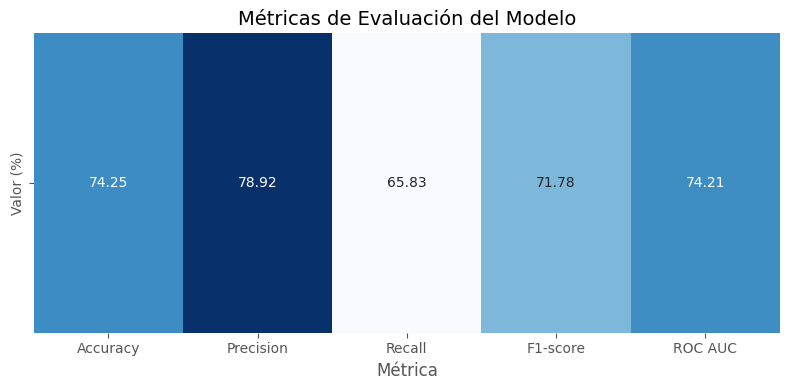

In [39]:
# Dataframe con las métricas en porcentaje
metrics_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
    'Valor': [accuracy, precision, recall, f1, roc_auc]
})
metrics_df['Valor (%)'] = (metrics_df['Valor'] * 100).round(2)


# Crear de imagen resumen con méticas

fig, ax = plt.subplots(figsize=(8, 4))  # Ajusta el tamaño si es necesario

sns.heatmap(
    metrics_df[['Métrica', 'Valor (%)']].set_index('Métrica').T,
    annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax
)

ax.set_title('Métricas de Evaluación del Modelo', fontsize=14)
plt.tight_layout()

# Guarda la tabla como una imagen
plt.savefig('metricas_modelo.png')

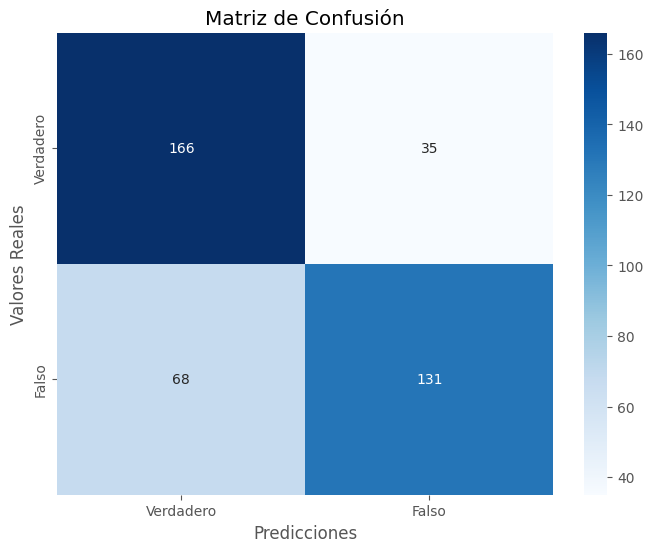

In [40]:
# Predicciones del modelo en el conjunto de prueba
y_pred = model_1.predict(X_test_dtm)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Imagen matriz de confusión
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de Confusión')

ax.xaxis.set_ticklabels(['Verdadero', 'Falso'])
ax.yaxis.set_ticklabels(['Verdadero', 'Falso'])

# Guardar la figura como una imagen PNG
plt.savefig('matriz_confusion.png')

# Mostrar la matriz de confusión
plt.show()